In [ ]:
pip install googletrans==3.1.0a0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 3.5 MB/s 
     |████████████████████████████████| 1.4 MB 52.0 MB/s 
     |████████████████████████████████| 42 kB 1.3 MB/s 
     |████████████████████████████████| 53 kB 2.1 MB/s 
     |████████████████████████████████| 65 kB 4.0 MB/s 
  Created wheel for googletrans: filename=googletrans-3.1.0a0-py3-none-any.whl size=16367 sha256=09e7f742e87a6eef826986ff2d3aaf067794de4f757812aaab774e2c28d67ffd
  Stored in directory: /root/.cache/pip/wheels/0c/be/fe/93a6a40ffe386e16089e44dad9018ebab9dc4cb9eb7eab65ae
Successfully built googletrans


In [ ]:
import nltk
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import string
import numpy as np
from helpers import label_reviews, clean_review, remove_non_alpha
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import (multilabel_confusion_matrix, 
                             classification_report,
                             plot_confusion_matrix,
                             ConfusionMatrixDisplay
                            )
import time
import warnings
warnings.filterwarnings("ignore")
import joblib
import matplotlib.pyplot as plt

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
df = pd.read_csv('Translated_London_Hotel_review_Dataset.csv')
df.head()

,Review Rating,Translated Review
0,4,Wonderful stay Found the hotel via Tripadvisor...
1,5,Business Dinner!! Recently attended the Passen...
2,5,Very nice boutique hotel. Recommended although...
3,5,Amazing stay Very last minute overnight stay. ...
4,5,Fantastic Hotel!! I stayed at this hotel for t...


In [ ]:
df['label'] = df['Review Rating'].apply(label_reviews)
df.head()

,Review Rating,Translated Review,label
0,4,Wonderful stay Found the hotel via Tripadvisor...,pos
1,5,Business Dinner!! Recently attended the Passen...,pos
2,5,Very nice boutique hotel. Recommended although...,pos
3,5,Amazing stay Very last minute overnight stay. ...,pos
4,5,Fantastic Hotel!! I stayed at this hotel for t...,pos


In [ ]:
df['Translated Review'] = df['Translated Review'].apply(remove_non_alpha)

In [ ]:
df['Translated Review'].replace('', np.nan, inplace=True)

In [ ]:
df = df.dropna()

In [ ]:
df.isna().sum()

Review Rating        0
Translated Review    0
label                0
dtype: int64

In [ ]:
stopwords = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer()
df['Clean Review'] = df['Translated Review'].apply(lambda x: clean_review(ps, stopwords, x))
df.head()

,Review Rating,Translated Review,label,Clean Review
0,4,Wonderful stay Found the hotel via Tripadvisor...,pos,"[wonder, stay, found, hotel, via, tripadvisor,..."
1,5,Business Dinner Recently attended the Passen...,pos,"[busi, dinner, recent, attend, passeng, ship, ..."
2,5,Very nice boutique hotel Recommended although...,pos,"[nice, boutiqu, hotel, recommend, although, ro..."
3,5,Amazing stay Very last minute overnight stay ...,pos,"[amaz, stay, last, minut, overnight, stay, boo..."
4,5,Fantastic Hotel I stayed at this hotel for t...,pos,"[fantast, hotel, stay, hotel, three, night, se..."


In [ ]:
# TF-IDF
tfidf_vect = TfidfVectorizer(analyzer=(lambda x: clean_review(ps, stopwords, x)))
X_tfidf = tfidf_vect.fit_transform(df['Translated Review'])
X_tfidf_feat = pd.DataFrame(X_tfidf.toarray())
X_tfidf_feat.head()
# Since it is a sparse matrix so most of the values are zeros.

,0,1,2,3,4,5,6,7,8,9,...,14958,14959,14960,14961,14962,14963,14964,14965,14966,14967
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# CountVectorizer
count_vect = CountVectorizer(analyzer=(lambda x: clean_review(ps, stopwords, x)))
X_count = count_vect.fit_transform(df['Translated Review'])
X_count_feat = pd.DataFrame(X_count.toarray())
X_count_feat.head()
# Since it is a sparse matrix so most of the values are zeros.

,0,1,2,3,4,5,6,7,8,9,...,14958,14959,14960,14961,14962,14963,14964,14965,14966,14967
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Compare GridSearchCV result and find best hyperparameter tunning.

In [ ]:
# To overcome class imbalance.
class_wgt = class_weight.compute_class_weight('balanced', classes=np.unique(pd.factorize(df['label'])[0]), y= pd.factorize(df['label'])[0])
class_wgt

array([0.37582146, 5.15484159, 6.88849135])

In [ ]:
class_wgt_dict = dict(zip( df['label'].unique(),class_wgt))
class_wgt_dict

{'neg': 6.888491353607633,
 'neu': 5.154841588576528,
 'pos': 0.37582145878066237}

In [ ]:
# Stratification to overcome class imbalance.
skf_5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=151)

In [ ]:
RandomForestClassifier().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [ ]:
model_rf = RandomForestClassifier()
param = {
    'n_estimators' : [100, 150],
    'max_depth' : [7, 11, 15],
    'class_weight' : [class_wgt_dict]
}

y_label = df['label']

grid_search_tfidf = GridSearchCV(model_rf, 
                                param_grid=param,
                                cv=skf_5,
                                n_jobs=-1)

gb_fit_tfidf = grid_search_tfidf.fit(X_tfidf_feat, y_label)

In [ ]:
# Get first 5 best scores and their corresponding hyperparameter for TF-IDF 
pd.DataFrame(grid_search_tfidf.cv_results_).sort_values('mean_test_score', ascending=False)[:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,30.200927,3.828602,0.451642,0.158128,"{'pos': 0.37582145878066237, 'neu': 5.15484158...",15,150,"{'class_weight': {'pos': 0.37582145878066237, ...",0.913457,0.916486,0.912121,0.911255,0.909091,0.912482,0.002454,1
4,21.621519,0.283440,0.382462,0.011312,"{'pos': 0.37582145878066237, 'neu': 5.15484158...",15,100,"{'class_weight': {'pos': 0.37582145878066237, ...",0.910861,0.909563,0.910390,0.913853,0.909957,0.910925,0.001527,2
3,25.116912,0.331126,0.413771,0.006305,"{'pos': 0.37582145878066237, 'neu': 5.15484158...",11,150,"{'class_weight': {'pos': 0.37582145878066237, ...",0.898745,0.901341,0.910823,0.904762,0.900866,0.903307,0.004225,3
2,16.933471,0.234916,0.361189,0.006716,"{'pos': 0.37582145878066237, 'neu': 5.15484158...",11,100,"{'class_weight': {'pos': 0.37582145878066237, ...",0.903505,0.900909,0.907792,0.903030,0.890476,0.901142,0.005783,4
1,17.208758,0.504224,0.379020,0.008207,"{'pos': 0.37582145878066237, 'neu': 5.15484158...",7,150,"{'class_weight': {'pos': 0.37582145878066237, ...",0.864994,0.881869,0.886147,0.878788,0.871429,0.876645,0.007552,5


The mean_test_score with TF-IDF is 0.910146

In [ ]:
# Best hyper parameter configuration for TF-IDF
gb_fit_tfidf.best_params_

{'class_weight': {'neg': 6.888491353607633,
  'neu': 5.154841588576528,
  'pos': 0.37582145878066237},
 'max_depth': 15,
 'n_estimators': 150}

In [ ]:
grid_search_count = GridSearchCV(model_rf, 
                           param_grid=param,
                           cv=skf_5,
                           n_jobs=-1)

gb_fit_count_vec = grid_search_count.fit(X_count_feat, y_label)

In [ ]:
# Get first 5 best scores and their corresponding hyperparameter for TF-IDF 
pd.DataFrame(gb_fit_count_vec.cv_results_).sort_values('mean_test_score', ascending=False)[:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,29.517608,5.296381,0.415800,0.085457,"{'pos': 0.37582145878066237, 'neu': 5.15484158...",15,150,"{'class_weight': {'pos': 0.37582145878066237, ...",0.909563,0.914323,0.914719,0.914719,0.906926,0.912050,0.003220,1
3,24.945218,0.191552,0.436341,0.006052,"{'pos': 0.37582145878066237, 'neu': 5.15484158...",11,150,"{'class_weight': {'pos': 0.37582145878066237, ...",0.909563,0.918650,0.916017,0.906494,0.905628,0.911270,0.005188,2
4,22.020780,0.207816,0.408265,0.009296,"{'pos': 0.37582145878066237, 'neu': 5.15484158...",15,100,"{'class_weight': {'pos': 0.37582145878066237, ...",0.913457,0.910861,0.920779,0.909091,0.900866,0.911011,0.006450,3
2,17.344612,0.358508,0.410808,0.042513,"{'pos': 0.37582145878066237, 'neu': 5.15484158...",11,100,"{'class_weight': {'pos': 0.37582145878066237, ...",0.901774,0.907399,0.904762,0.905195,0.900000,0.903826,0.002622,4
1,16.790872,0.227387,0.405682,0.010272,"{'pos': 0.37582145878066237, 'neu': 5.15484158...",7,150,"{'class_weight': {'pos': 0.37582145878066237, ...",0.888793,0.897880,0.889610,0.896104,0.890476,0.892573,0.003690,5


The mean_test_score with count vectorizer is 0.912569 

In [ ]:
# Best hyper parameter configuration for TF-IDF
gb_fit_count_vec.best_params_

{'class_weight': {'neg': 6.888491353607633,
  'neu': 5.154841588576528,
  'pos': 0.37582145878066237},
 'max_depth': 15,
 'n_estimators': 150}

##Final Model with best hyperparameters from Grid Search

In [ ]:
# Split data in to train test split. 80% train and 20% test.
X_train, X_test, y_train, y_test = train_test_split(df[['Translated Review']], 
                                                    df['label'], 
                                                    test_size=0.2)

Vectorize the text: Since the mean_test_score for Count vectorizer and TF-IDF is very close. Choosing TF-IDF Since it gives importance to less frequent word.

In [ ]:
tfidf_vect = TfidfVectorizer(analyzer=(lambda x : clean_review(ps, stopwords, x)))
tfidf_vect_fit = tfidf_vect.fit(X_train['Translated Review'])

tfidf_train = tfidf_vect_fit.transform(X_train['Translated Review'])
tfidf_test = tfidf_vect_fit.transform(X_test['Translated Review'])

X_train_vect =  pd.DataFrame(tfidf_train.toarray())
X_test_vect =  pd.DataFrame(tfidf_test.toarray())

X_train_vect.head()

,0,1,2,3,4,5,6,7,8,9,...,13486,13487,13488,13489,13490,13491,13492,13493,13494,13495
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
random_forest = RandomForestClassifier(n_estimators=150, 
                                        max_depth=15,
                                        class_weight=class_wgt_dict, 
                                        n_jobs=-1)

start = time.time()
rf_model_final = random_forest.fit(X_train_vect, y_train)
end = time.time()
fit_time = (end - start)

start = time.time()
y_pred = rf_model_final.predict(X_test_vect)
end = time.time()
pred_time = (end - start)

accuracy = round((y_pred==y_test).sum()/len(y_pred), 3) * 100

print(f'Fit time: {fit_time} secs Predict time: {pred_time} secs Accuracy: {accuracy}')

Fit time: 14.88193154335022 secs Predict time: 0.23145222663879395 secs Accuracy: 90.60000000000001


## Evaluation

In [ ]:
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
class_names = df['label'].unique()

Confusion matrix, without normalization
[[  65   12   35]
 [  24   17  120]
 [  17   10 2011]]
Normalized confusion matrix
[[0.58035714 0.10714286 0.3125    ]
 [0.14906832 0.10559006 0.74534161]
 [0.00834151 0.00490677 0.98675172]]


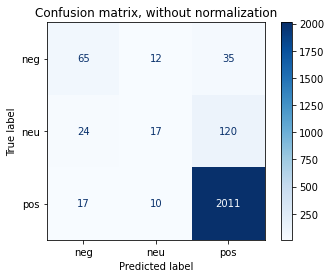

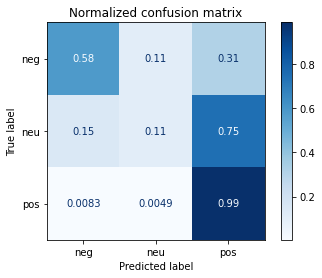

In [ ]:
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        rf_model_final,
        X_test_vect,
        y_test,
        #display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

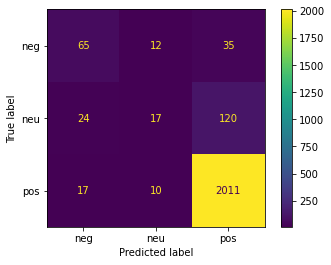

In [ ]:
plot_confusion_matrix(rf_model_final, X_test_vect, y_test)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         neg       0.61      0.58      0.60       112
         neu       0.44      0.11      0.17       161
         pos       0.93      0.99      0.96      2038

    accuracy                           0.91      2311
   macro avg       0.66      0.56      0.57      2311
weighted avg       0.88      0.91      0.88      2311



##Save the model

In [ ]:
filename="random_forest_model"
joblib.dump(rf_model_final, filename)

['random_forest_model']